In [11]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import glob
from keras.preprocessing.image import ImageDataGenerator

from importlib.resources import path
from keras.applications import MobileNetV2, EfficientNetV2B2, EfficientNetB0, VGG16
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, GlobalAveragePooling2D, InputLayer, LeakyReLU
from keras.models import Sequential, Model
from keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download Dataset

In [2]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
!gsutil -mq cp gs://tibot-ml-labeling/datasets/cats_vs_dogs_dataset.zip ./

# Unzip Dataset

In [ ]:
# !rm -rf 'dataset'

In [ ]:
!unzip cats_vs_dogs_dataset.zip

# Data Preprocessing

In [5]:
train_dir = 'dataset/train'
test_dir = 'dataset/test'

image_width =224
image_height =224
image_size =(image_width, image_height)

batch_size=8

In [6]:
datagen= ImageDataGenerator(rescale=1./255,
                                  horizontal_flip= True,
                                  vertical_flip= True,
                                  rotation_range=15,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode= 'nearest',
                                  validation_split = 0.2)

train_data = datagen.flow_from_directory(directory=train_dir,
                                           target_size= image_size,
                                           batch_size= batch_size,
                                           subset = 'training',
                                           seed=123)

val_data = datagen.flow_from_directory(directory=train_dir,
                                           target_size= image_size,
                                           batch_size= batch_size,
                                           subset = 'validation',
                                           seed=123)

test_datagen= ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                           target_size= image_size,
                                           batch_size= batch_size)

Found 14392 images belonging to 2 classes.
Found 3598 images belonging to 2 classes.
Found 4732 images belonging to 2 classes.


# Custom callback for save model

In [ ]:
from keras.callbacks import Callback,History,EarlyStopping
class SaveModel(Callback):
  def __init__(self, model_name, model):
    self.model_name = model_name
    self.model = model
  def on_epoch_end(self, epoch, logs=None):
    if epoch == 0:
      filepath = f"drive/MyDrive/cats_vs_dogs_task/{self.model_name}/model/Cats_Vs_Dogs_{self.model_name}-{epoch+1:02d}.h5"

      self.model.save(filepath, include_optimizer=True)

      !gsutil -mq cp {filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/{self.model_name}/model/
      print(" Save model after one epoch")

# EfficientNetV2B2 model

In [4]:
# Load the EfficientNetV2B2 model
base_model = EfficientNetV2B2(weights=None, include_top=False, input_shape=(224,224,3))

# Add a global average pooling layer to reduce dimensions and connect it to a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

# Combine the base model and custom layers to create the final model
eff_model = Model(inputs=base_model.input, outputs=output)

# Print a summary of the model architecture
eff_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0][0]']      

In [65]:
from keras.optimizers import Adam
import os
save_model = SaveModel(model_name = 'EfficientNetV2B2', model = eff_model)

eff_filepath="drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNetV2B2.h5"
# Create a ModelCheckpoint instance
checkpoint = ModelCheckpoint(
    eff_filepath,                 # File path to save the checkpoint
    monitor='acc',
    verbose=1,                # Verbosity level (0, 1, or 2) for logging
    save_weights_only=False,  # Whether to save only the model weights or the entire model
    save_best_only=True,      # Save only the best model based on the monitored metric
    mode='max'                # Mode for comparison, 'max' for accuracy-like metrics
)

earlystopping = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights = True)
adam = Adam(learning_rate=.0001)

# Compile the model
eff_model.compile(optimizer=adam,
                    loss=CategoricalCrossentropy(),
                    metrics = ["acc"])

eff_model.fit(train_data, validation_data=(val_data),verbose=1, epochs=3, callbacks=[save_model,checkpoint,earlystopping])

Epoch 1/3
1799/1799 [==============================] - ETA: 0s - loss: 0.5686 - acc: 0.7080 Save model after one epoch

Epoch 1: acc improved from -inf to 0.70803, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNetV2B2.h5
1799/1799 [==============================] - 352s 187ms/step - loss: 0.5686 - acc: 0.7080 - val_loss: 5.0635 - val_acc: 0.4911
Epoch 2/3
1799/1799 [==============================] - ETA: 0s - loss: 0.5158 - acc: 0.7482
Epoch 2: acc improved from 0.70803 to 0.74819, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNetV2B2.h5
1799/1799 [==============================] - 329s 183ms/step - loss: 0.5158 - acc: 0.7482 - val_loss: 6.4516 - val_acc: 0.4997
Epoch 3/3
1799/1799 [==============================] - ETA: 0s - loss: 0.4842 - acc: 0.7738
Epoch 3: acc improved from 0.74819 to 0.77376, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNet

592/592 [==============================] - 16s 28ms/step


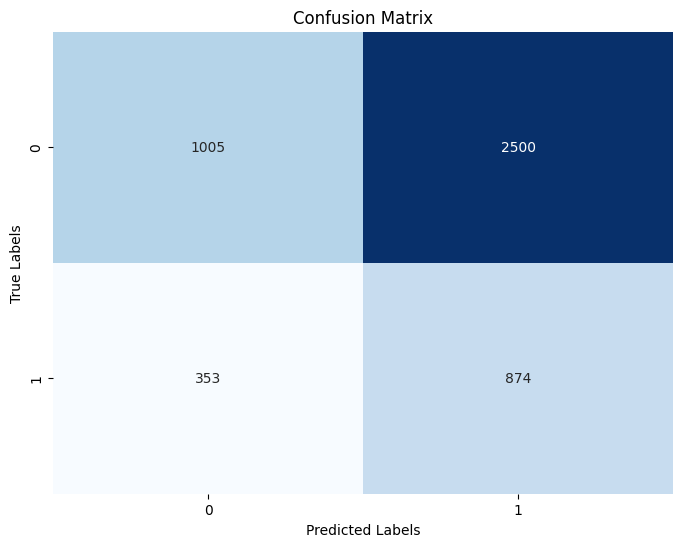

              precision    recall  f1-score   support

           0       0.74      0.29      0.41      3505
           1       0.26      0.71      0.38      1227

    accuracy                           0.40      4732
   macro avg       0.50      0.50      0.40      4732
weighted avg       0.62      0.40      0.40      4732



In [23]:
# Load model
eff_model_load = load_model('drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNetV2B2.h5')

# Generate predictions on test data
predictions = eff_model_load.predict(test_data)

# Convert predictions to binary class labels (0 or 1)
predictions_classes = np.argmax(predictions, axis=1)

# Get labels from test generator
labels = test_data.classes

# Calculate confusion matrix
confusion = confusion_matrix(labels, predictions_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
# Generate classification report
classification_rep = classification_report(labels, predictions_classes)
print( classification_rep)

# EfficientNetV2B2 model with ImageNet

In [70]:
# Load the EfficientNetV2B2 model
base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add a global average pooling layer to reduce dimensions and connect it to a dense layer for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2, activation='softmax')(x)

# Combine the base model and custom layers to create the final model
eff_model1 = Model(inputs=base_model.input, outputs=output)

# Print a summary of the model architecture
eff_model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  0          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [71]:
from keras.optimizers import Adam
import os
save_model = SaveModel(model_name = 'EfficientNetV2B2FT', model = eff_model1)

eff_filepath1="drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2FT/model/Cats_vs_Dogs_EfficientNetV2B2FT.h5"
# Create a ModelCheckpoint instance
checkpoint = ModelCheckpoint(
    eff_filepath1,                 # File path to save the checkpoint
    monitor='acc',
    verbose=1,                # Verbosity level (0, 1, or 2) for logging
    save_weights_only=False,  # Whether to save only the model weights or the entire model
    save_best_only=True,      # Save only the best model based on the monitored metric
    mode='max'                # Mode for comparison, 'max' for accuracy-like metrics
)

earlystopping = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights = True)
adam = Adam(learning_rate=.0001)

# Compile the model
eff_model1.compile(optimizer=adam,
                    loss=CategoricalCrossentropy(),
                    metrics = ["acc"])

eff_model1.fit(train_data, validation_data=(val_data),verbose=1, epochs=3, callbacks=[save_model,checkpoint,earlystopping])

Epoch 1/3
1799/1799 [==============================] - ETA: 0s - loss: 0.1779 - acc: 0.9282 Save model after one epoch

Epoch 1: acc improved from -inf to 0.92815, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2FT/model/Cats_vs_Dogs_EfficientNetV2B2FT.h5
1799/1799 [==============================] - 359s 191ms/step - loss: 0.1779 - acc: 0.9282 - val_loss: 0.2124 - val_acc: 0.9013
Epoch 2/3
1799/1799 [==============================] - ETA: 0s - loss: 0.0695 - acc: 0.9747
Epoch 2: acc improved from 0.92815 to 0.97471, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2FT/model/Cats_vs_Dogs_EfficientNetV2B2FT.h5
1799/1799 [==============================] - 326s 181ms/step - loss: 0.0695 - acc: 0.9747 - val_loss: 0.0519 - val_acc: 0.9811
Epoch 3/3
1799/1799 [==============================] - ETA: 0s - loss: 0.0458 - acc: 0.9842
Epoch 3: acc improved from 0.97471 to 0.98423, saving model to drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2FT/model/Cats_vs_Dogs_Ef

592/592 [==============================] - 18s 27ms/step


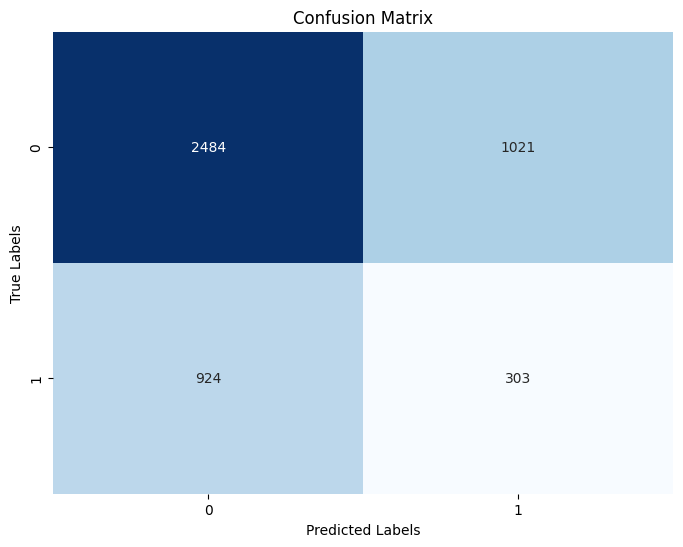

              precision    recall  f1-score   support

           0       0.73      0.71      0.72      3505
           1       0.23      0.25      0.24      1227

    accuracy                           0.59      4732
   macro avg       0.48      0.48      0.48      4732
weighted avg       0.60      0.59      0.59      4732



In [25]:
# Load model
eff_model_load = load_model('drive/MyDrive/cats_vs_dogs_task/EfficientNetV2B2FT/model/Cats_vs_Dogs_EfficientNetV2B2FT.h5')

# Generate predictions on test data
predictions = eff_model_load.predict(test_data)

# Convert predictions to binary class labels (0 or 1)
predictions_classes = np.argmax(predictions, axis=1)

# Get labels from test generator
labels = test_data.classes

# Calculate confusion matrix
confusion = confusion_matrix(labels, predictions_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
# Generate classification report
classification_rep = classification_report(labels, predictions_classes)
print( classification_rep)

# VGG16

In [15]:
vgg16_model = VGG16(weights=None, include_top=False, input_shape=(224,224,3))

flat = Flatten() (vgg16_model.output)
dropout1 = Dropout(0.2, name="Dropout1") (flat)
dense1 = Dense(128, activation="relu")(dropout1)
dropout2 = Dropout(0.2, name="Dropout2")(dense1)
output = Dense(2, activation="softmax") (dropout2)

vgg_final_model = Model(inputs=[vgg16_model.input], outputs=[output])

In [73]:
save_model = SaveModel(model_name = 'VGG16', model = vgg_final_model)

vgg_filepath="drive/MyDrive/cats_vs_dogs_task/VGG16/model/Cats_vs_Dogs_VGG16.h5"
# Create a ModelCheckpoint instance
checkpoint = ModelCheckpoint(
    vgg_filepath,                 # File path to save the checkpoint
    monitor='acc',
    verbose=1,                # Verbosity level (0, 1, or 2) for logging
    save_weights_only=False,  # Whether to save only the model weights or the entire model
    save_best_only=True,      # Save only the best model based on the monitored metric
    mode='max'                # Mode for comparison, 'max' for accuracy-like metrics
)

earlystopping = EarlyStopping(monitor="val_loss",
                                        mode="min",
                                        patience=5,
                                        restore_best_weights = True)
adam = Adam(learning_rate=.0001)

# Compile the model
vgg_final_model.compile(optimizer=adam,
                    loss=CategoricalCrossentropy(),
                    metrics = ["acc"])

vgg_final_model.fit(train_data, validation_data=(val_data),verbose=1, epochs=3, callbacks=[save_model,checkpoint,earlystopping])

Epoch 1/3
1799/1799 [==============================] - ETA: 0s - loss: 0.6555 - acc: 0.6480 Save model after one epoch

Epoch 1: acc improved from -inf to 0.64800, saving model to drive/MyDrive/cats_vs_dogs_task/VGG16/model/Cats_vs_Dogs_VGG16.h5
1799/1799 [==============================] - 298s 165ms/step - loss: 0.6555 - acc: 0.6480 - val_loss: 0.6466 - val_acc: 0.6492
Epoch 2/3
1799/1799 [==============================] - ETA: 0s - loss: 0.6415 - acc: 0.6642
Epoch 2: acc improved from 0.64800 to 0.66419, saving model to drive/MyDrive/cats_vs_dogs_task/VGG16/model/Cats_vs_Dogs_VGG16.h5
1799/1799 [==============================] - 285s 158ms/step - loss: 0.6415 - acc: 0.6642 - val_loss: 0.6288 - val_acc: 0.6848
Epoch 3/3
1799/1799 [==============================] - ETA: 0s - loss: 0.6290 - acc: 0.6773
Epoch 3: acc improved from 0.66419 to 0.67725, saving model to drive/MyDrive/cats_vs_dogs_task/VGG16/model/Cats_vs_Dogs_VGG16.h5
1799/1799 [==============================] - 284s 158ms/st

592/592 [==============================] - 33s 52ms/step


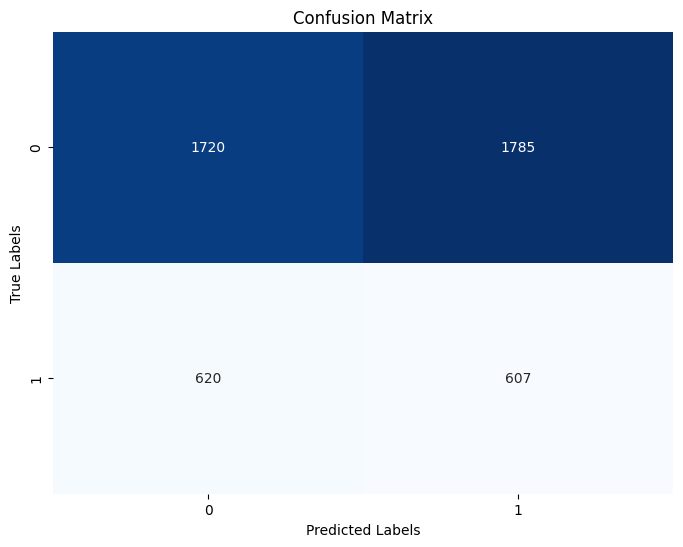

              precision    recall  f1-score   support

           0       0.74      0.49      0.59      3505
           1       0.25      0.49      0.34      1227

    accuracy                           0.49      4732
   macro avg       0.49      0.49      0.46      4732
weighted avg       0.61      0.49      0.52      4732



In [26]:
# Load model
model_load = load_model('drive/MyDrive/cats_vs_dogs_task/VGG16/model/Cats_vs_Dogs_VGG16.h5')

# Generate predictions on test data
predictions = model_load.predict(test_data)

# Convert predictions to binary class labels (0 or 1)
predictions_classes = np.argmax(predictions, axis=1)

# Get labels from test generator
labels = test_data.classes

# Calculate confusion matrix
confusion = confusion_matrix(labels, predictions_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
# Generate classification report
classification_rep = classification_report(labels, predictions_classes)
print( classification_rep)

# Custom model

In [10]:
model = keras.Sequential()

model.add(InputLayer(input_shape=(image_width, image_height, 3)))

model.add(Conv2D(filters=32,kernel_size=(3,3), activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())


model.add(Flatten()) #


model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(2, activation="sigmoid"))


model.compile(optimizer=Adam(0.001),loss = BinaryCrossentropy(),metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               2

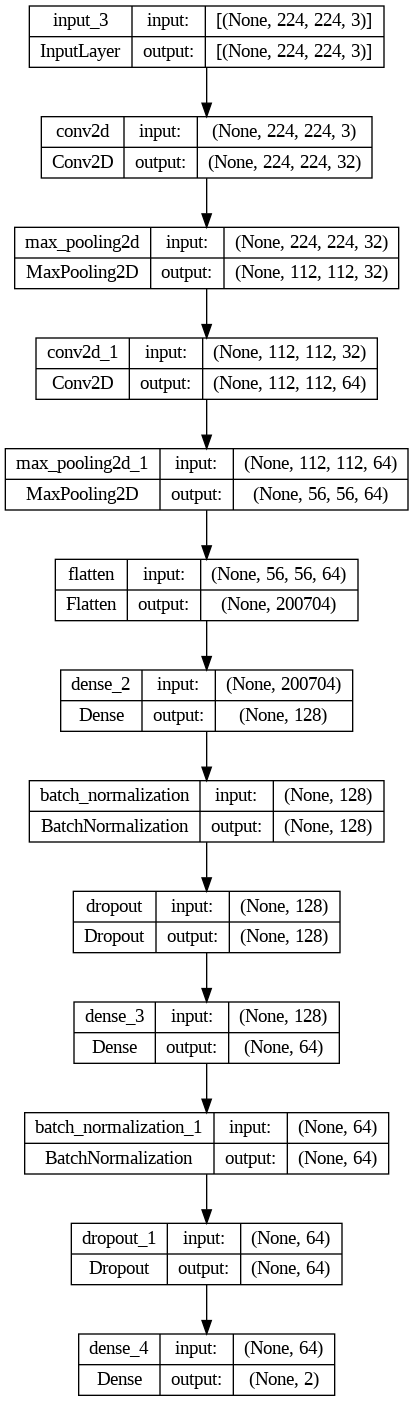

In [19]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True,
    show_layer_names=True,
)

In [75]:
save_model = SaveModel(model_name = 'CustomModel', model = model)

custom_filepath="drive/MyDrive/cats_vs_dogs_task/CustomModel/model/Cats_vs_Dogs_CustomModel.h5"
# Create a ModelCheckpoint instance
checkpoint = ModelCheckpoint(
    custom_filepath,                 # File path to save the checkpoint
    monitor='accuracy',
    verbose=1,                # Verbosity level (0, 1, or 2) for logging
    save_weights_only=False,  # Whether to save only the model weights or the entire model
    save_best_only=True,      # Save only the best model based on the monitored metric
    mode='max'                # Mode for comparison, 'max' for accuracy-like metrics
)
model.fit(train_data,
            callbacks = [save_model, checkpoint],
            epochs=3,
            validation_data=(val_data))

Epoch 1/3
1799/1799 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.7589 Save model after one epoch

Epoch 1: accuracy improved from -inf to 0.75889, saving model to drive/MyDrive/cats_vs_dogs_task/CustomModel/model/Cats_vs_Dogs_CustomModel.h5
1799/1799 [==============================] - 310s 173ms/step - loss: 0.5059 - accuracy: 0.7589 - val_loss: 0.6658 - val_accuracy: 0.5850
Epoch 2/3
1799/1799 [==============================] - ETA: 0s - loss: 0.4994 - accuracy: 0.7610
Epoch 2: accuracy improved from 0.75889 to 0.76105, saving model to drive/MyDrive/cats_vs_dogs_task/CustomModel/model/Cats_vs_Dogs_CustomModel.h5
1799/1799 [==============================] - 259s 144ms/step - loss: 0.4994 - accuracy: 0.7610 - val_loss: 1.0098 - val_accuracy: 0.5742
Epoch 3/3
1799/1799 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.7706
Epoch 3: accuracy improved from 0.76105 to 0.77057, saving model to drive/MyDrive/cats_vs_dogs_task/CustomModel/model/

592/592 [==============================] - 11s 19ms/step


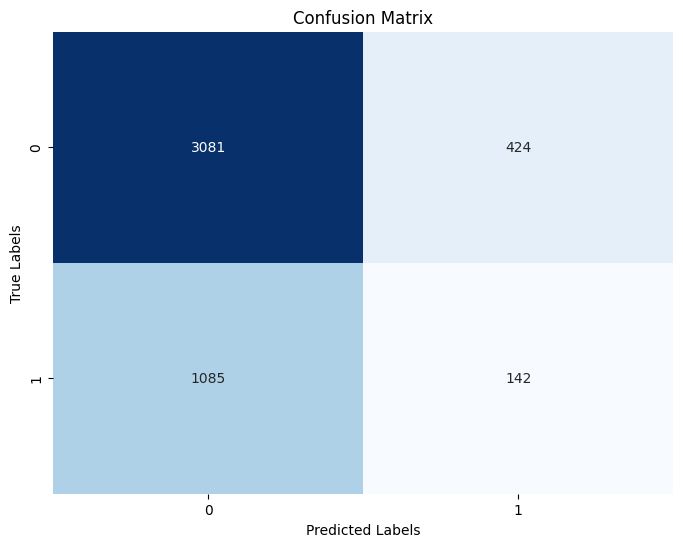

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      3505
           1       0.25      0.12      0.16      1227

    accuracy                           0.68      4732
   macro avg       0.50      0.50      0.48      4732
weighted avg       0.61      0.68      0.64      4732



In [27]:
# Load model
model_load = load_model('drive/MyDrive/cats_vs_dogs_task/CustomModel/model/Cats_vs_Dogs_CustomModel.h5')

# Generate predictions on test data
predictions = model_load.predict(test_data)

# Convert predictions to binary class labels (0 or 1)
predictions_classes = np.argmax(predictions, axis=1)

# Get labels from test generator
labels = test_data.classes

# Calculate confusion matrix
confusion = confusion_matrix(labels, predictions_classes)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
# Generate classification report
classification_rep = classification_report(labels, predictions_classes)
print( classification_rep)

In [7]:
!gsutil -mq cp {eff_filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2/model/
!gsutil -mq cp {eff_filepath1} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2FT/model/
!gsutil -mq cp {vgg_filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/VGG16/model/
!gsutil -mq cp {custom_filepath} gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/CustomModel/model/


In [13]:
!gsutil ls gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/**

gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/CustomModel/model/Cats_Vs_Dogs_CustomModel-01.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/CustomModel/model/Cats_vs_Dogs_CustomModel.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2/model/Cats_Vs_Dogs_EfficientNetV2B2-01.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2/model/Cats_vs_Dogs_EfficientNetV2B2.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2FT/model/Cats_Vs_Dogs_EfficientNetV2B2FT-01.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/EfficientNetV2B2FT/model/Cats_vs_Dogs_EfficientNetV2B2FT.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/VGG16/model/Cats_Vs_Dogs_VGG16-01.h5
gs://tibot-ml-labeling/models/cats_vs_dogs_task/diganto/VGG16/model/Cats_vs_Dogs_VGG16.h5


# Title: Multi-Model Training Documentation for Cats vs. Dogs Classification

## Introduction:
This task outlines the process of training multiple models for a Cats vs. Dogs classification task. The task involves classifying images as either cats or dogs. Four different models have been employed for this task: EfficientNetV2B2, a custom CNN model, VGG16, and a Transfer Learning approach using EfficientNetV2B2. The training data is augmented using various image data augmentation techniques.

## Model Training Workflow:

1. **Data Preprocessing:**

- Cat and dog images are gathered and stored in separate directories: "cat_images" and "dog_images".
- Data augmentation is applied to the training dataset using the ImageDataGenerator class.

2. **Model 1: EfficientNetV2B2 (Initial Training)**

- EfficientNetV2B2 model is loaded without pre-trained weights.
- A global average pooling layer and a dense layer are added for classification.
- The model is compiled with Adam optimizer and Categorical Crossentropy loss.
- Training is performed on the augmented training data.
- A custom callback, SaveModel, is used to save the model at the end of one epoch.
- Checkpoints are saved locally and uploaded to Google Cloud Storage.

3. **Model 2: EfficientNetV2B2 (Fine-Tuning)**

- EfficientNetV2B2 model is loaded with pre-trained ImageNet weights.
- Additional layers are added for classification, and the model is compiled.
- Training is performed on the augmented training data, including early stopping, custom callback and checkpoints.

4. **Model 3: Custom CNN Model**

- A custom CNN model is designed with Conv2D and Dense layers.
- The model is compiled with Adam optimizer and Binary Crossentropy loss.
- Training is performed on the augmented training data.
- A custom callback, SaveModel, is used to save the model at the end of one epoch.

5. **Model 4: Transfer Learning with VGG16**

- VGG16 model is loaded without pre-trained weights. (excluding top layers).
- Additional layers are added for classification, and the model is compiled.
- Training is performed on the augmented training data, including early stopping and checkpoints.

## Result:

| Model                          | Accuracy |
|--------------------------------|----------|
| Custom Model                   | 0.68     |
| EfficientNetV2B2 (ImageNet)    | 0.59     |
| VGG                            | 0.49     |
| EfficientNetV2B2                | 0.40     |

## Conclusion:
This task illustrates the process of training multiple models for a Cats vs. Dogs classification task. Each model is trained using augmented training data, and different architecture approaches are explored. The combination of image data augmentation and well-structured model training processes contributes to achieving accurate classification results for the given task